In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#SHOW ALL PICTURE

images = glob.glob('data/*.jpg')
images = images + glob.glob('data/*.bmp')
print(images)

# img = []
# for idx, fname in enumerate(images):
#     gray = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
#     img.append(gray)

['data/0002.jpg', 'data/makeup_after.jpg', 'data/Afghan_girl_after.jpg', 'data/Afghan_girl_before.jpg', 'data/0001.jpg', 'data/makeup_before.jpg', 'data/bird.bmp', 'data/einstein.bmp', 'data/motorcycle.bmp', 'data/marilyn.bmp', 'data/bicycle.bmp', 'data/plane.bmp', 'data/fish.bmp', 'data/dog.bmp', 'data/cat.bmp', 'data/submarine.bmp']


In [3]:
# SHOW ONLY ONE PICTURE
img = []
img.append(cv2.imread('data/0001.jpg', cv2.IMREAD_GRAYSCALE))

In [4]:
# k=2
layer = 5
sigma = 1

x, y = np.mgrid[-2:3, -2:3]
kernel = np.exp(-(x**2+y**2)/(2* sigma**2)) / (sigma**2)
kernel = kernel/kernel.sum()

In [5]:
def smooth(in_img):
    num_row = in_img.T[0].size #331=height
    num_col = in_img[0].size #375 = width
    k=int( (kernel[0].size-1)/2 )
#     print(k)
    img = np.zeros((num_row+k*2, num_col+k*2))
    result = np.zeros((num_row, num_col))
    
    #PADDING
    img[k:k+num_row, k:k+num_col]=in_img
    for c in range(num_col+k*2):
        for i in range(k):
            img[i, c] = img[k, c]
            img[k+num_row+i, c] = img[k+num_row-1, c]
            
    for r in range(num_row+k*2):
        for i in range(k):
            img[r, i] = img[r, k]
            img[r, k+num_col+i] = img[r, k+num_col-1]
    
    #CONVOLUTION
    for irow in range(k, k+num_row): 
        for icol in range(k, k+num_col):
            tmp=0.0
            for krow in range(-k, k+1):
                for kcol in range(-k, k+1):
                    tmp += kernel[krow+k, kcol+k]*img[irow-krow, icol-kcol]
            result[irow-k, icol-k]= int(tmp)
            
    return result

In [6]:
conv_test=[ [] for i in range(len(img)) ]  #first pic is origin pic, conv start from second

for idx in range(len(img)):
    conv_test[idx].append(img[idx])
    for ly in range(layer):
        conv_test[idx].append( smooth(conv_test[idx][ly]) )

In [7]:
def pyrdown(img):
    in_row = img.T[0].size #331=height
    in_col = img[0].size #375 = width
    result = np.zeros((int(in_row/2), int(in_col/2)))
    out_row = result.T[0].size
    out_col = result[0].size
    
    ga = smooth(img)
    for r in range(out_row):
        for c in range(out_col):
            result[r,c] = ga[r*2+1, c*2+1]
    return result

In [8]:
layer = 5
down_test=[ [] for i in range(len(img)) ]  #first pic is origin pic, conv start from second

for idx in range(len(img)):
    down_test[idx].append(img[idx])
    for ly in range(layer):
        down_test[idx].append( pyrdown(down_test[idx][ly]) )

In [9]:
def pyrup(img):
    in_row = img.T[0].size #height
    in_col = img[0].size #width
    
    out_row = in_row*2
    out_col = in_col*2
    result = np.zeros((out_row, out_col))
    
    
    for r in range(in_row):
        for c in range(in_col):
            result[r*2+1 ,c*2+1] = img[r,c]
            result[r*2+1, c*2] = img[r,c]
            result[r*2, c*2+1] = img[r,c]
            result[r*2, c*2] = img[r,c]
    return result
    

In [10]:
up_test=[ [] for i in range(len(img)) ]
up_test_smooth = [ [] for i in range(len(img)) ]

for idx in range(len(img)):
    for ly in range(layer):
        up_test_smooth[idx].append( smooth(pyrup(down_test[idx][ly+1]) ))
        up_test[idx].append( pyrup(down_test[idx][ly+1]) )

In [11]:
def Laplacian(img1, img2): #img1 = origin , img2 = after smooth
    row = img1.T[0].size #height
    col = img1[0].size #width
    result = np.zeros((row, col))
    
    for r in range(row):
        for c in range(col):
            if c>=img2[0].size: 
                result[r,c] = 0
            elif r>=img2.T[0].size:
                result[r,c] = 0
            else:
                result[r,c] = img1[r,c] - img2[r,c]
    return result

In [12]:
lap_test=[ [] for i in range(len(img)) ]
lap_test_smooth = [ [] for i in range(len(img)) ]

for idx in range(len(img)):
    for ly in range(layer):
        lap_test_smooth[idx].append( Laplacian(down_test[idx][ly], up_test_smooth[idx][ly]) )
        lap_test[idx].append( Laplacian(down_test[idx][ly], up_test[idx][ly]) )


In [13]:
f_conv=[ [] for i in range(len(img)) ]
f_lap=[ [] for i in range(len(img)) ]

for idx in range(len(img)):
    for ly in range(layer):
       
        #FOURIER TRANSFORM FOR GAUSSIAN 
        f = np.fft.fft2(down_test[idx][ly])
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        f_conv[idx].append(magnitude_spectrum)
    
        #FOURIER TRANSFORM FOR LAPLACIAN
        f = np.fft.fft2(lap_test_smooth[idx][ly])
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        f_lap[idx].append(magnitude_spectrum)
        

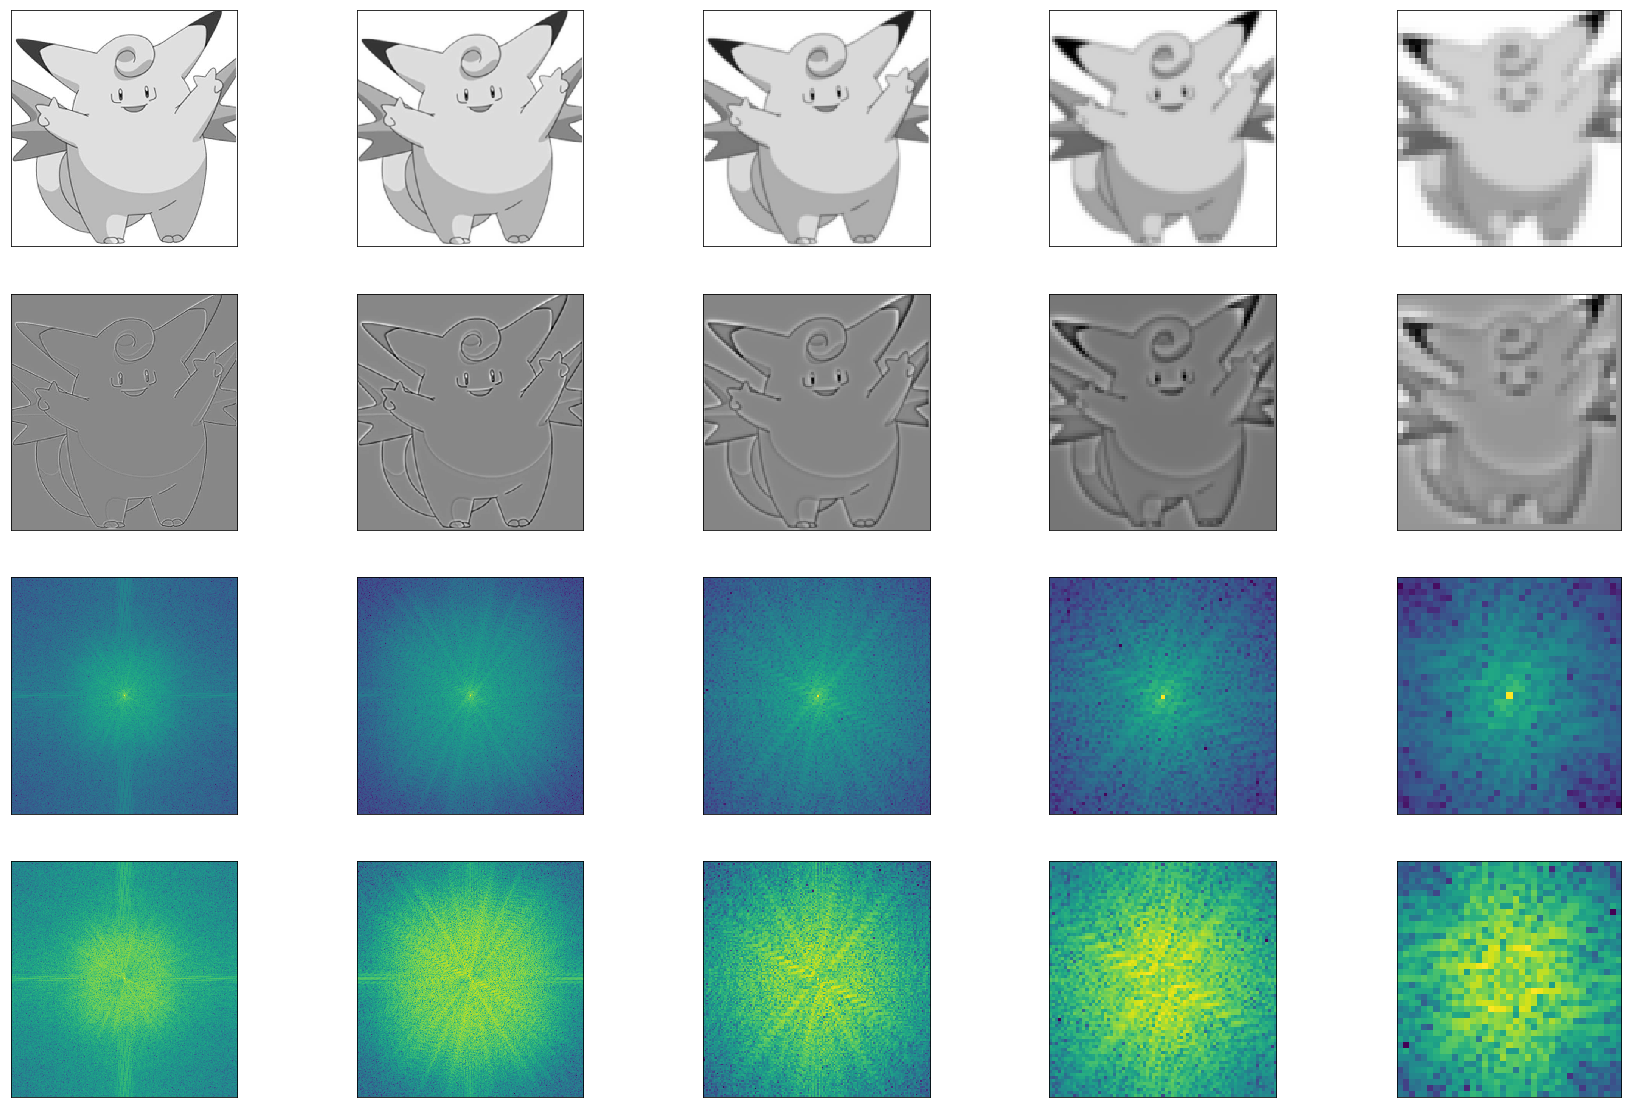

In [14]:
for idx in range(len(img)):
    plt.figure(figsize=(30,20))
    for i in range(5):
        plt.subplot(4,5,1+i)
        plt.xticks([]), plt.yticks([])
        plt.imshow(down_test[idx][i], cmap = 'gray')
        
        plt.subplot(4,5,6+i)
        plt.xticks([]), plt.yticks([])
        plt.imshow(lap_test_smooth[idx][i], cmap = 'gray')
        
        plt.subplot(4,5,11+i)
        plt.xticks([]), plt.yticks([])
        plt.imshow(f_conv[idx][i])
        
        plt.subplot(4,5,16+i)
        plt.xticks([]), plt.yticks([])
        plt.imshow(f_lap[idx][i])

# Use Build in Function to Check

In [15]:
# ex = []
# layerr = img[0].copy()
# gaussian_pyramid = [layerr]
# for i in range(6):
#     layerr = cv2.pyrDown(layerr)
#     gaussian_pyramid.append(layerr)

# # Laplacian Pyramid
# layerr = gaussian_pyramid[5]
# laplacian_pyramid = [layerr]
# for i in range(5, 0, -1):
#     size = (gaussian_pyramid[i - 1].shape[1], gaussian_pyramid[i - 1].shape[0])
#     gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i], dstsize=size)
#     ex.append(gaussian_expanded)
#     laplacian = cv2.subtract(gaussian_pyramid[i - 1], gaussian_expanded)
#     laplacian_pyramid.append(laplacian)
    
# #PLOT    
# plt.figure(figsize=(30,10))
# for i in range(5):
#     plt.subplot(2,6,1+i)
#     plt.imshow(gaussian_pyramid[i], cmap = 'gray')
#     plt.subplot(2,6,7+i)
#     plt.imshow(laplacian_pyramid[5-i], cmap = 'gray')